# IOOS models: Temperature Horizontal Slices

This is the second post on the series “IOOS Ocean Models IOOS.”

Thanks to standardized metadata and grid specs one read the data and compare different
models results.
In this post we will demostrante how to leverage Python's libraries to plot
horizontal temperature slices from a variety of ocean models with minimum specific code.

Be sure to check the [first post on the series](http://ioos.github.io/notebooks_demos/notebooks/2018-12-04-grids/).

In [1]:
models = {
    "DOPPIO": {
        "RA": "MARACOOS",
        "url": "http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "NYHOPS": {
        "RA": "MARACOOS",
        "url": "http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc",
        "var": {"standard_name": "sea_water_temperature"},
    },
    "NECOFS-GOM3": {
        "RA": "NERACOOS",
        "url": "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "NECOFS-MASSBAY": {
        "RA": "NERACOOS",
        "url": "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "CNAPS": {
        "RA": "SECOORA",
        "url": "http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "CMOP-SELFE": {
        "RA": "NANOOS",
        "url": "http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast",
        "var": {"standard_name": "average_sea_water_temperature"},
    },
    "OSU-ROMS": {
        "RA": "NANOOS",
        "url": "http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "Hawaii-ROMS": {
        "RA": "PacIOOS",
        "url": "http://oos.soest.hawaii.edu/thredds/dodsC/hioos/roms_forec/hiig/ROMS_Hawaii_Regional_Ocean_Model_best.ncd",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "WCOFS": {
        "url": "http://opendap.co-ops.nos.noaa.gov/thredds/dodsC/WCOFS/fmrc/Aggregated_7_day_WCOFS_Fields_Forecast_best.ncd",
        "var": {"standard_name": "sea_water_temperature"},
    },
    "WestCoastUCSC": {
        "url": "http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd",
        "var": {"long_name": "potential temperature"},
    },
}

We need loop over the models dictionary and load the grid and the variable of interest.

In [2]:
from gridgeo import GridGeo
from gridgeo.cfvariable import CFVariable
from netCDF4 import Dataset

for name in list(models):
    model = models[name]
    try:
        nc = Dataset(model["url"])
        var = CFVariable(nc, **model["var"])
        grid = GridGeo(nc, **model["var"])
        models[name].update({"nc": nc})
        models[name].update({"variable": var})
        models[name].update({"grid": grid})
    except (RuntimeError, ValueError, OSError) as e:
        print(f"Could not get data from {name}\n{e}")
        models.pop(name)

curl error details: 


Could not get data from NYHOPS
[Errno -68] NetCDF: I/O failure: b'http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc'
Could not get data from OSU-ROMS
[Errno -68] NetCDF: I/O failure: b'http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS'
Could not get data from Hawaii-ROMS
[Errno -72] NetCDF: Malformed or inaccessible DAP2 DDS or DAP4 DMR response: b'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/roms_forec/hiig/ROMS_Hawaii_Regional_Ocean_Model_best.ncd'
Could not get data from WCOFS
[Errno -68] NetCDF: I/O failure: b'http://opendap.co-ops.nos.noaa.gov/thredds/dodsC/WCOFS/fmrc/Aggregated_7_day_WCOFS_Fields_Forecast_best.ncd'


curl error details: 
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
curl error details: 


The main challenge is to figure out what layer is the surface in all
those models using only the metadata available with little "manual inspection."
The function `get_surface_idx` below uses the variable mesh information to figure that
out automatically for us.

In [3]:
def get_surface_idx(var, mesh):
    # Short-circuit if data does not have a z-axis.
    if ("ugrid" not in mesh.lower() and var.ndim == 3) or (
        "ugrid" in mesh.lower() and var.ndim == 2
    ):
        return None

    z = var.z_axis()
    if np.argmin(z.shape) == 0 and z.ndim == 2:
        points = z[:, 0]
    elif np.argmin(z.shape) == 1 and z.ndim == 2:
        points = z[0, :]
    else:
        points = z[:]

    positive = getattr(z, "positive", None)
    if positive == "up":
        idx = np.unique(points.argmax(axis=0))[0]
    elif positive == "down":
        idx = np.unique(points.argmin(axis=0))[0]
    else:
        raise ValueError(f'Cannot find property "positive" in {z}')
    return idx

Now that we know what is the surface layer we can get the data and its
bounding box for the figure.

In [4]:
def get_layer(var, mesh, layer, time_step=-1):
    if layer is None:
        return var[time_step, :]
    if var.ndim == 4 or "ugrid" in mesh.lower():
        return var[time_step, layer, ...]
    elif var.ndim == 3 and "ugrid" not in mesh.lower():
        return var[layer, ...]
    else:
        msg = "Cannot find the surface for var {!r}".format
        raise ValueError(msg(var))


def get_bbox(var, delta=0.1):
    x = var.x_axis()[:]
    y = var.y_axis()[:]
    return [np.min(x) - delta, np.max(x) + delta, np.min(y) - delta, np.max(y) + delta]

Last but not least we have `plot_surface_cfvar` that checks if we have a UGRID,
1-D or 2-D kind of mesh for the plotting.
We do have one special case, `NYHOPS`,
where the coordinates associated with the variable are not
the coordinates we need for plotting, so we need to add an exception code for that model.

In [5]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from cartopy.feature import COLORS, NaturalEarthFeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from palettable.cmocean.sequential import Thermal_20

cmap = Thermal_20.mpl_colormap

LAND = NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="black", facecolor=COLORS["land"]
)


def plot_surface_cfvar(var, grid, name, vlevel=None, time_step=-1):
    fig, ax = plt.subplots(
        figsize=(9, 9), subplot_kw={"projection": ccrs.PlateCarree()},
    )
    if name == "NYHOPS":
        # This model is non-standard and the CF-model won't work here
        # b/c the coordinates associated with the temperature variable have NaNs
        # and we need to pull this x, y coordinates that are not listed in the variable.
        nc = model["nc"]
        x, y = nc["x"][:], nc["y"][:]
    else:
        x = var.x_axis()[:]
        y = var.y_axis()[:]

    if name == "WestCoastUCSC":
        # The surface has many NaNs for some reason, so we plot the second level.
        vlevel -= 1
    z = get_layer(var, grid.mesh, layer=vlevel, time_step=time_step)

    # Using masked data only to get `vmin` and `vmax`
    # b/c tripcolor cannot take masked data :-(
    # This workaround is need to plot the Columbia River data.
    masked = np.ma.masked_greater_equal(z, 9.96921e36)
    vmin, vmax = np.nanmin(masked), np.nanmax(masked)
    kw = {
        "cmap": cmap,
        "zorder": 0,
        "vmin": vmin,
        "vmax": vmax,
    }

    bbox = get_bbox(var)
    ax.set_extent(bbox)

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.ylines = gl.xlines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.add_feature(LAND, zorder=1, edgecolor="black")

    if grid.mesh == "ugrid":
        faces = grid.triang.triangles
        cs = ax.tripcolor(x, y, z, triangles=faces, **kw,)
    else:
        cs = ax.pcolormesh(x, y, z, **kw)

    units = getattr(var, "units", "None")
    if units in ["degree_Celsius", "degrees_C", "Celsius"]:
        units = "℃"
    cbar = fig.colorbar(cs, extend="both", shrink=0.65)
    cbar.ax.set_title(units)
    ax.set_title(f"{name}")
    return fig, ax

Finally we can loop over the models plot them all:

/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


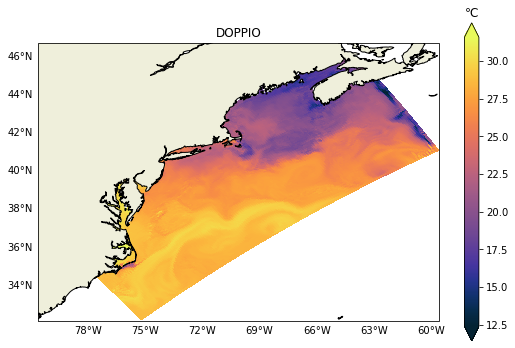

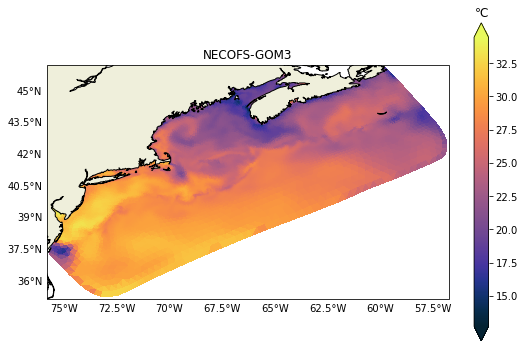

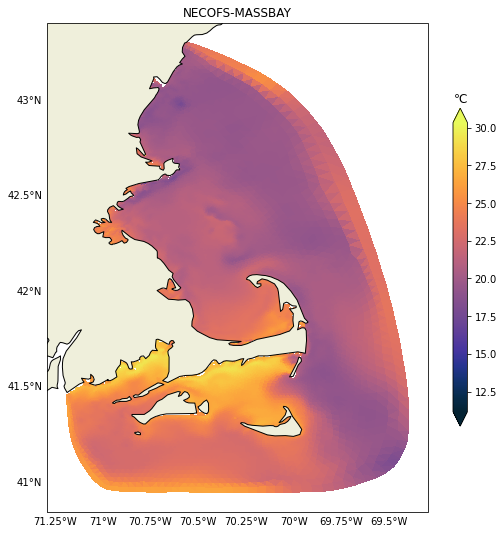

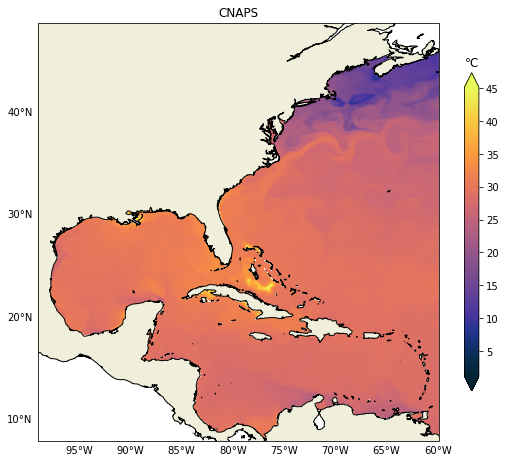

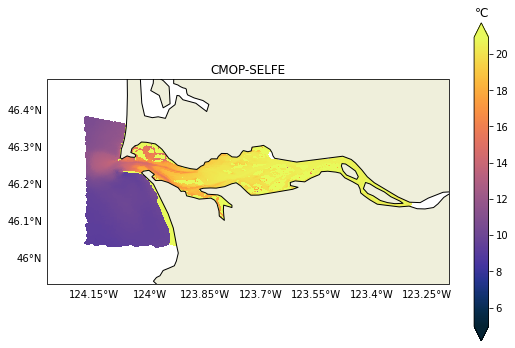

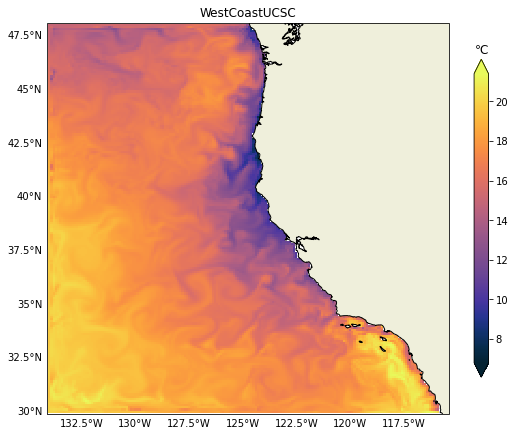

In [6]:
for name in models.keys():
    model = models[name]
    grid = model["grid"]
    var = model["variable"]
    vlevel = get_surface_idx(var, grid.mesh)
    fig, ax = plot_surface_cfvar(var, grid, name, vlevel=vlevel, time_step=-1)

It is relatively easy to change to any other variable like salinity for example.
In the next post we will demonstrate how to plot vertical sections,
those can be challenging due to the heterogeneity of vertical coordinates in the models.